In [3]:
%pylab inline
import os
import sys
import cv2
import numpy as np

from matplotlib import pyplot as plt

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.5/dist-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['gray']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [4]:
%pylab inline
import os
import sys
import cv2
import numpy as np

image = cv2.imread("Image1.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)


# sift
sift = cv2.xfeatures2d.SIFT_create()
(kps, descs) = sift.detectAndCompute(gray, None)
print("# kps: {}, descriptors: {}".format(len(kps), descs.shape))

# Surf
surf = cv2.xfeatures2d.SURF_create()
(kps, descs) = surf.detectAndCompute(gray, None)
print("# kps: {}, descriptors: {}".format(len(kps), descs.shape))


# Detect the CenSurE key points
star = cv2.xfeatures2d.StarDetector_create()
kps = star.detect(gray, None)
# Create the BRIEF extractor and compute the descriptors
brief = cv2.xfeatures2d.BriefDescriptorExtractor_create()
kps, descs = brief.compute(img, kps)
print("# kps: {}, descriptors: {}".format(len(kps), descs.shape))

# 

orb = cv2.ORB_create()
(kps, descs) = orb.detectAndCompute(gray, None)
print("# kps: {}, descriptors: {}".format(len(kps), descs.shape))

kaze = cv2.KAZE_create()
(kps, descs) = kaze.detectAndCompute(gray, None)
print("# kps: {}, descriptors: {}".format(len(kps), descs.shape))

akaze = cv2.AKAZE_create()
(kps, descs) = akaze.detectAndCompute(gray, None)
print("# kps: {}, descriptors: {}".format(len(kps), descs.shape))

brisk = cv2.BRISK_create()
(kps, descs) = brisk.detectAndCompute(gray, None)
print("# kps: {}, descriptors: {}".format(len(kps), descs.shape))


# Paint the key points over the original image
result = cv2.drawKeypoints(image, keyPoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

imshow(image)

Populating the interactive namespace from numpy and matplotlib
# kps: 1488, descriptors: (1488, 128)
# kps: 2583, descriptors: (2583, 64)


NameError: name 'img' is not defined

In [5]:

# Load the image
img = cv2.imread('Image1.jpg')

# Convert it to gray scale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Detect the CenSurE key points
star = cv2.xfeatures2d.StarDetector_create()
kps = star.detect(gray, None)

# Create the BRIEF extractor and compute the descriptors
brief = cv2.xfeatures2d.BriefDescriptorExtractor_create()
kps, descs = brief.compute(img, kps)
print("# kps: {}, descriptors: {}".format(len(kps), descs.shape))

# Paint the key points over the original image
result = cv2.drawKeypoints(img, keyPoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Display the results
imshow(result)


# kps: 277, descriptors: (277, 32)


NameError: name 'keyPoints' is not defined

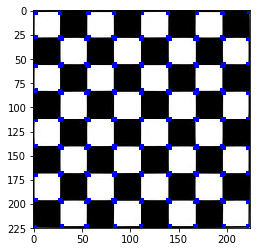

In [6]:
filename = 'Chess.jpg'
img = cv2.imread(filename)
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

gray = np.float32(gray)
dst = cv2.cornerHarris(gray,2,3,0.04)

#result is dilated for marking the corners, not important
dst = cv2.dilate(dst,None)

# Threshold for an optimal value, it may vary depending on the image.
img[dst>0.01*dst.max()]=[0,0,255]

imshow(img)

In [7]:
# Initialize features
# http://opencv-python-tutroals.readthedocs.org/en/latest/py_tutorials/py_feature2d/py_matcher/py_matcher.html?highlight=flann_index_kdtree
# feature name: sift, surf, orb
# flann = True, False
def init_feature(feature_name, flann):
    FLANN_INDEX_KDTREE = 0  # bug: flann enums are missing
    FLANN_INDEX_LSH    = 6    
    
    if feature_name == 'surf':
        detector = cv2.SURF(800)
        norm = cv2.NORM_L2
    elif feature_name == 'orb':
        detector = cv2.ORB(400)
        norm = cv2.NORM_HAMMING
    else: 
        return None, None

    if flann == True:
        print ("Flann: ", flann)
        if norm == cv2.NORM_L2:
            flann_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
        else:
            flann_params = dict(algorithm = FLANN_INDEX_LSH,
                                table_number = 6,
                                key_size = 12,
                                multi_probe_level = 1)
        matcher = cv2.FlannBasedMatcher(flann_params, {})
    else:
        print ("Flann: ", flann)         
        matcher = cv2.BFMatcher(norm)
        
    return detector, matcher

In [8]:
# filter matches with a threshhold
def filter_matches(kp1, kp2, matches, ratio):
    print ("Ratio: ", ratio)
    mkp1, mkp2 = [], []
    for m in matches:
        if len(m) == 2 and m[0].distance < m[1].distance * ratio:
            m = m[0]
            mkp1.append( kp1[m.queryIdx] )
            mkp2.append( kp2[m.trainIdx] )
    p1 = np.float32([kp.pt for kp in mkp1])
    p2 = np.float32([kp.pt for kp in mkp2])
    kp_pairs = zip(mkp1, mkp2)
    
    return p1, p2, kp_pairs

In [9]:
# Finds strong corresponding features in the two given vectors
# http://stackoverflow.com/questions/8301962/opencv-pythons-api-flannbasedmatcher/8311498#8311498
def match_flann(desc1, desc2, r_threshold = 0.06):
    # Build a kd-tree from the second feature vector
    FLANN_INDEX_KDTREE = 1
    flann = cv2.flann_Index(desc2, {'algorithm': FLANN_INDEX_KDTREE, 'trees':4})
    
    #FLANN_INDEX_KDTREE = 0
    #index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    #search_params = dict() 
    #flann = cv2.FlannBasedMatcher(index_params,search_params)
    #matches = flann.knnMatch(desc1,desc2,k=2)
    
    #matchesMask = [[0,0] for i in xrange(len(matches))]
    
    #for i,(m,n) in enumerate(matches):
    #    if m.distance < 0.7*n.distance:
    #        matchesMask[i]=True

    #idx1 = np.arange(len(desc1))
    
    # for each feature in desc1, find the two closest ones in desc2
    (idx2, dist) = flann.knnSearch(desc1, 2, params = {})
    
    # Create a mask that indicates if the first-round item is sufficiently
    # closer than the second-round True or False
    mask = dist[:,0] / dist[:,1] < r_threshold
    
    # Only return robust feature pairs
    idx1 = np.arange(len(desc1))
    pairs = np.int32(zip(idx1, idx2[:,0]))
    
    return pairs[mask]

In [10]:
# Extract SURF keypoints and descriptors from an image
def extract_features(image, feature, flann):
    print ("Converting image...")
    # convert image to grayscle
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Gaussian blur
    gray_image = cv2.GaussianBlur(gray_image, (5,5), 0)    
    
    print ("Initialize feature...")
    detector, matcher = init_feature(feature, flann)
    
    print ("extracting features...")
    kp, des = detector.detectAndCompute(gray_image, None)

    # Define SURF return descriptor in n x 64
    #surf = cv2.SURF(surfThreshold, extended = False)
    
    # Compute key points and descriptor
    #keypoints, descriptors = surf.detectAndCompute(gray_image, None)
   
    return (kp, des)

In [ ]:
# find matched features
def match_features(kp1, des1, kp2, des2, feature, flann, ratio):
    # initialize feature detector
    detector, matcher = init_feature(feature, flann)
    
    # find matches
    matches = matcher.knnMatch(des1, des2, k = 2)
    print ("Matches: %d" %len(matches))
        
    # filter the matches
    p1, p2, kp_pairs = filter_matches(kp1, kp2, matches, ratio)
        
    return p1, p2, kp_pairs    

In [ ]:
# Find correspondence between two images
def find_correspondences(keypoints1, descriptors1, keypoints2, descriptors2):
    # find corresponding features
    match = match_flann(descriptors1, descriptors2)
   
    kp1 = []
    kp2 = []
    
    for i in range(len(match)):
        kp1.append(keypoints1[match[i][0]])
        kp2.append(keypoints2[match[i][1]])
    
    # look up corresponding keypoints
    points1 = np.array([k.pt for k in kp1], np.float32)
    points2 = np.array([k.pt for k in kp2], np.float32)
    
    return (points1, points2)

In [ ]:
# draw keypoints and line between matched keypoints
def draw_match(img1, img2, kp_pairs, status = None, H = None):
    # define new size for two images
    h1, w1 = img1.shape[:2]
    h2, w2 = img2.shape[:2]
    vis = np.zeros((max(h1, h2), w1+w2, 3), np.uint8)
    vis[:h1, :w1] = img1
    vis[:h2, w1:w1+w2] = img2
    #vis = cv2.cvtColor(vis, cv2.COLOR_BGR2RGB)
    
    red = (255, 0, 0)
    green = (0, 255, 0)
    blue = (0, 0, 255)
    white = (255, 255, 255)
    kp_color = (51, 103, 236)
    
    # define a box
    if H is not None:
        corners = np.float32([[0,0], [w1,0], [w1,h1], [0,h1]])
        corners = np.int32( cv2.perspectiveTransform(corners.reshape(1, -1, 2), H).reshape(-1, 2) + (w1, 0) )        
        cv2.polylines(vis,[corners], True, (255,255,255))
    
    # inlier
    if status is None:
        status = np.ones(len(kp_pairs), np.bool_)
    p1 = np.int32([kpp[0].pt for kpp in kp_pairs])
    p2 = np.int32([kpp[1].pt for kpp in kp_pairs]) + (w1, 0)
    
    # draw lines
    for(x1, y1), (x2, y2), inlier in zip(p1, p2, status):
        if inlier:
            col = green
            cv2.circle(vis, (x1, y1), 2, col, -1)
            cv2.circle(vis, (x2, y2), 2, col, -1)
        else:
            col = red
            r = 2
            thickness = 3
            cv2.line(vis, (x1-r, y1-r), (x1+r, y1+r), col, thickness)
            cv2.line(vis, (x1-r, y1+r), (x1+r, y1-r), col, thickness)
            cv2.line(vis, (x2-r, y2-r), (x2+r, y2+r), col, thickness)
            cv2.line(vis, (x2-r, y2+r), (x2+r, y2-r), col, thickness)
    vis0 = vis.copy()
    for(x1, y1), (x2, y2), inlier in zip(p1, p2, status):
        if inlier:
            cv2.line(vis, (x1, y1), (x2, y2), green)   
    
    # draw keypoints
    idx = len(kp_pairs)
    kp1, kp2 = [], []
    
    for i in range(idx):
        k1, k2 = kp_pairs[i]
        kp1.append(k1)
        kp2.append(k2)
    
    vis = cv2.drawKeypoints(vis, kp1, color=white)
    vis[:,w1:] = cv2.drawKeypoints(vis[:,w1:], kp2, color=white)
   
    
    return vis        
        

In [ ]:
# Connects corresponding features in the two images using yellow lines
def draw_correspondences(image1, image2, points1, points2):
    # Put images side-by-side into'image'
    (h1, w1) = image1.shape[:2]
    (h2, w2) = image2.shape[:2]
    image = np.zeros((max(h1, h2), w1 + w2, 3), np.uint8)
    image[:h1, :w1] = image1
    image[:h2, w1:w1+w2] = image2
    
    # Draw yellow lines connecting corresponding features
    for(x1, y1), (x2, y2) in zip(np.int32(points1), np.int32(points2)):
        cv2.line(image, (x1,y1), (x2+w1, y2), (0,255,255), lineType = cv2.CV_AA)
        
    return image

In [ ]:
# Calculate the size and offset of the stitched panorama
# http://stackoverflow.com/questions/13063201/how-to-show-the-whole-image-when-using-opencv-warpperspective/20355545#20355545
def calculate_size(size_image1, size_image2, homography):
    # Calculate the size and offset of the stitched panorama
    (h1, w1) = size_image1[:2]
    (h2, w2) = size_image2[:2]
    
    # corners of each each image
    pts1 = np.float32([[0,0],[0,h1],[w1,h1],[w1,0]]).reshape(-1,1,2)
    pts2 = np.float32([[0,0],[0,h2],[w2,h2],[w2,0]]).reshape(-1,1,2)
    pts2_t = cv2.perspectiveTransform(pts2,homography)
    
    # concatenate two point sets
    pts = np.concatenate((pts1, pts2_t), axis = 0)    
  
    # min and max points
    [xmin, ymin] = np.int32(pts.min(axis = 0).ravel() - 0.5)
    [xmax, ymax] = np.int32(pts.max(axis = 0).ravel() + 0.5)
    
    # size and offset
    size = (xmax-xmin, ymax-ymin)
    offset = (-xmin,-ymin)

    
    # Update the homegraphy to shift by the offset
    # homography[0:2,2] += offset
    
    return (size, offset)

In [ ]:
# Combine images into a panorama
def merge_images(image1, image2, homography, size, offset, keypoints):
    # translate
    Ht = np.array([[1,0,offset[0]],[0,1,offset[1]],[0,0,1]])
    #H = np.dot(Ht, homography)
    H = Ht.dot(homography)
    
    # warp image2 to image1
    (h1, w1) = image1.shape[:2]
    (h2, w2) = image2.shape[:2]
    panorama = np.zeros((size[1], size[0],3), np.uint8)

    #http://docs.opencv.org/2.3/modules/imgproc/doc/geometric_transformations.html#cv2.warpPerspective  
    panorama = cv2.warpPerspective(image2, H, size)
    panorama[offset[1]:h1+offset[1], offset[0]:w1+offset[0]] = image1
  
    # draw the common feature keypoints
    #http://docs.opencv.org/2.3/modules/calib3d/doc/camera_calibration_and_3d_reconstruction.html#cv2.drawChessboardCorners
   
    kp1 = keypoints[0]
    kp2 = keypoints[1]

    # apply translation to keypoint set 1      
    for i in range(len(kp1)):
        kp1[i][0] += offset[0]
        kp1[i][1] += offset[1]    
        
    kp1_t = np.float32(kp1).reshape(-1,1,2)

    # apply translation to keypoint set 2
    kp2_t = np.float32(kp2).reshape(-1,1,2)
    kp2_t = cv2.perspectiveTransform(kp2_t, H)
    
    cv2.drawChessboardCorners(panorama, (7,6), kp1_t, False)       
    cv2.drawChessboardCorners(panorama, (7,6), kp2_t, False)     
    
    return panorama
    

In [ ]:
# stitching function
# feature: 'sift', 'surf', 'org'
# flann: True, False
def stitch(image1, image2, feature, flann = False, ratio = 0.35):
    print ("Loading image...")
    img1 = cv2.imread(image1)
    img2 = cv2.imread(image2)

    # convert color space
    #img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
    #img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)    

    # detect features and compute descriptors
    print ("Extracting features...")
    (keypoints1, descriptors1) = extract_features(img1, feature, flann)
    (keypoints2, descriptors2) = extract_features(img2, feature, flann)

    # match features
    print ("Finding matched features...")
    p1, p2, kp_pairs = match_features(keypoints1, descriptors1, keypoints2, descriptors2, feature, flann, ratio)
    print (len(p1), "features matched")
    
    # find correspondence
    #print "Finding corresponding points..."
    #(points1, points2) = find_correspondences(keypoints1, descriptors1, keypoints2, descriptors2)
    #print len(points1), "features matched"

    # find homography
    print ("Finding homography...")   
    #homography, status = cv2.findHomography(p1, p2, cv2.RANSAC, 5.0)

    src_pts = float32(p2).reshape(-1,1,2)    
    dst_pts = float32(p1).reshape(-1,1,2)

    homography, status = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    
    # Visualize corresponding features
    print ("Drawing correspondences...")
    img = draw_match(img1, img2, kp_pairs, status, homography)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize = (32,16))
    plt.title("Feature: " + feature.upper() + " /Flann: " + str(flann) + " /Ratio: " + str(ratio), fontsize=20) 
    plt.imshow(img)
    plt.show()    
    
    # Calculate size and offset of merged panorama
    print ("Calculating stitched size...")
    (size, offset) = calculate_size(img1.shape, img2.shape, homography)
    
    # Combine images into a panorama
    print ("Merging images...")
    pan_img = merge_images(img1, img2, homography, size, offset, (p1, p2))
    
    #cv2.imwrite("panorama.jpg", panorama)
    
    return pan_img

In [ ]:
# Test stitching...
img1 = "Image1.jpg"
img2 = "Image2.jpg"

print ("Stitching starts...")

# start time
t_start = cv2.getTickCount()

pan1 = stitch(img1, img2, 'sift')

# end time
t_end = cv2.getTickCount()
t_total = (t_end - t_start) / cv2.getTickFrequency()

print ("Stitching complete!")
print ("Total time elapsed: %f seconds\n" %t_total)

In [ ]:
pimg = cv2.cvtColor(pan1, cv2.COLOR_BGR2RGB)
plt.figure(figsize = (32,16))
plt.imshow(pimg)
plt.show()

In [ ]:
# Test stitching...
img1 = "Image1.jpg"
img2 = "Image2.jpg"

print ("Stitching starts...")

# start time
t_start = cv2.getTickCount()

pan2 = stitch(img1, img2, 'sift', True)

# end time
t_end = cv2.getTickCount()
t_total = (t_end - t_start) / cv2.getTickFrequency()

print ("Stitching complete!")
print ("Total time elapsed: %f seconds\n" %t_total)

In [ ]:
pimg = cv2.cvtColor(pan2, cv2.COLOR_BGR2RGB)
plt.figure(figsize = (32,16))
plt.imshow(pimg)
plt.show()

In [ ]:
pimg = cv2.cvtColor(pan, cv2.COLOR_BGR2RGB)
plt.figure(figsize = (32,16))
plt.imshow(pimg)
plt.show()

In [ ]:
# Test stitching...
img1 = "Picture1.jpg"
img2 = "Picture2.jpg"

print "Stitching starts..."

# start time
t_start = cv2.getTickCount()

pan = stitch(img1, img2, 'sift', True, 0.6)

# end time
t_end = cv2.getTickCount()
t_total = (t_end - t_start) / cv2.getTickFrequency()

print "Stitching complete!"
print "Total time elapsed: %f seconds\n" %t_total

In [ ]:
pimg = cv2.cvtColor(pan, cv2.COLOR_BGR2RGB)
plt.figure(figsize = (32,16))
plt.imshow(pimg)
plt.show()

In [ ]:
# Test stitching...
img1 = "Picture1.jpg"
img2 = "Picture2.jpg"

print "Stitching starts..."

# start time
t_start = cv2.getTickCount()

pan = stitch(img1, img2, 'surf', False, 0.6)

# end time
t_end = cv2.getTickCount()
t_total = (t_end - t_start) / cv2.getTickFrequency()

print "Stitching complete!"
print "Total time elapsed: %f seconds\n" %t_total

In [ ]:
pimg = cv2.cvtColor(pan, cv2.COLOR_BGR2RGB)
plt.figure(figsize = (32,16))
plt.imshow(pimg)
plt.show()

In [ ]:
# Test stitching...
img1 = "Picture1.jpg"
img2 = "Picture2.jpg"

print "Stitching starts..."

# start time
t_start = cv2.getTickCount()

pan = stitch(img1, img2, 'surf', True, 0.6)

# end time
t_end = cv2.getTickCount()
t_total = (t_end - t_start) / cv2.getTickFrequency()

print "Stitching complete!"
print "Total time elapsed: %f seconds\n" %t_total

In [ ]:
pimg = cv2.cvtColor(pan, cv2.COLOR_BGR2RGB)
plt.figure(figsize = (32,16))
plt.imshow(pimg)
plt.show()

In [ ]:
# Test stitching...
img1 = "Picture1.jpg"
img2 = "Picture2.jpg"

print "Stitching starts..."

# start time
t_start = cv2.getTickCount()

pan = stitch(img1, img2, 'orb', False, 0.6)

# end time
t_end = cv2.getTickCount()
t_total = (t_end - t_start) / cv2.getTickFrequency()

print "Stitching complete!"
print "Total time elapsed: %f seconds\n" %t_total

In [ ]:
pimg = cv2.cvtColor(pan, cv2.COLOR_BGR2RGB)
plt.figure(figsize = (32,16))
plt.imshow(pimg)
plt.show()

In [ ]:
# Test stitching...
img1 = "Picture1.jpg"
img2 = "Picture2.jpg"

print "Stitching starts..."

# start time
t_start = cv2.getTickCount()

pan = stitch(img1, img2, 'orb', True, 0.6)

# end time
t_end = cv2.getTickCount()
t_total = (t_end - t_start) / cv2.getTickFrequency()

print "Stitching complete!"
print "Total time elapsed: %f seconds\n" %t_total

In [ ]:
pimg = cv2.cvtColor(pan, cv2.COLOR_BGR2RGB)
plt.figure(figsize = (32,16))
plt.imshow(pimg)
plt.show()

In [ ]:
# stitching x-ray image
# can not use stitch function
# need to process individually
# extract feature, find matches, find the center point of each cluster, translate two images

# read images
img1 = cv2.imread("002.TIF")
img2 = cv2.imread("003.TIF")

img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)

img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)



In [ ]:
plt.figure(figsize = (16,8))
plt.imshow(sift_img1)
title("image 1")

plt.figure(figsize = (16,8))
plt.imshow(sift_img2)
title("image 2")

plt.show()

In [ ]:
# mask
(h1, w1) = img1.shape[:2]
(h2, w2) = img2.shape[:2]

print (h1, w1), (h2, w2)

mask1 = np.zeros((h1,w1), np.uint8)
mask2 = np.zeros((h2,w2), np.uint8)

y = 0
x = w1 * 0.9

mask1[y:h1/5, x:w1-1] = 255
mask2[y:h2/5, 0:w2-x-1] = 255

In [ ]:
plt.figure(figsize = (16,8))
plt.imshow(mask1)
title("mask1")

plt.figure(figsize = (16,8))
plt.imshow(mask2)
title("mask2")

plt.show()

In [ ]:
# SIFT
blue = (255,0,0)
green = (0,255,0)
red = (0,0,255)
white = (255,255,255)


sift_detector, sift_matcher = init_feature('sift', False)
sift_kp1, sift_des1 = sift_detector.detectAndCompute(img1_gray, mask1)
sift_kp2, sift_des2 = sift_detector.detectAndCompute(img2_gray, mask2)


#sift_img1 = cv2.drawKeypoints(img1_gray, sift_kp1, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
#sift_img2 = cv2.drawKeypoints(img2_gray, sift_kp2, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

sift_img1 = cv2.drawKeypoints(img1, sift_kp1, color=red)
sift_img2 = cv2.drawKeypoints(img2, sift_kp2, color=red)

In [ ]:
# Match descriptors.
sift_matches = sift_matcher.knnMatch(sift_des1,sift_des2, k = 2)

p1, p2, kp_pairs = filter_matches(sift_kp1, sift_kp2, sift_matches, 0.8)
print len(p1)

In [ ]:
# homography
H, status = cv2.findHomography(p2, p1, cv2.RANSAC, 5.0)
print '%d / %d  inliers/matched' % (np.sum(status), len(status))

In [ ]:
img = draw_match(img1, img2, kp_pairs, status, H)
plt.figure(figsize = (32,16))
plt.title('Matched Keypoints', fontsize=20) 
plt.imshow(img)
plt.show()

In [ ]:
# calculate average center of the two center points
cp1 = np.mean(p1, axis=0)
cp2 = np.mean(p2, axis=0)
diff = cp1 - cp2

print cp1, cp2
print diff

offset_w1 = w1 - cp1[0]
offset_w2 = cp2[0]

offset_h = diff[1]

print offset_h
print offset_w1, offset_w2


In [ ]:
# translate image2 to image1
(h1, w1) = img1.shape[:2]
(h2, w2) = img2.shape[:2]

print (h1, w1), (h2, w2)

h = max(h1, h2) + offset_h
w = (w1 + w2) - offset_w1 - 2*offset_w2 + 1

panorama = np.zeros((h, w, 3), np.uint8)

print panorama.shape
panorama[0:h1, 0:w1-offset_w1] = img1[0:h1, 0:w1-offset_w1]
panorama[offset_h:h2+offset_h, w1-offset_w1:w] = img2[0:h2, offset_w2:w2-offset_w2]


In [ ]:
plt.figure(figsize = (32,16))
plt.title('Stitched Image', fontsize=20) 
plt.imshow(panorama)
plt.show()